## Import Required Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")


TensorFlow version: 2.20.0
Keras version: 3.11.3


##  Data Loading and Exploration


In [ ]:
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')
meta_df = pd.read_csv('Meta.csv')

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Meta data shape:", meta_df.shape)

print("\nTraining data sample:")
print(train_df.head())

print("\nTest data sample:")
print(test_df.head())

print("\nMeta data sample:")
print(meta_df.head())


Training data shape: (39209, 8)
Test data shape: (12630, 8)
Meta data shape: (43, 5)

Training data sample:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  

Test data sample:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/0000

Number of classes: 43
Class range: 0 to 42


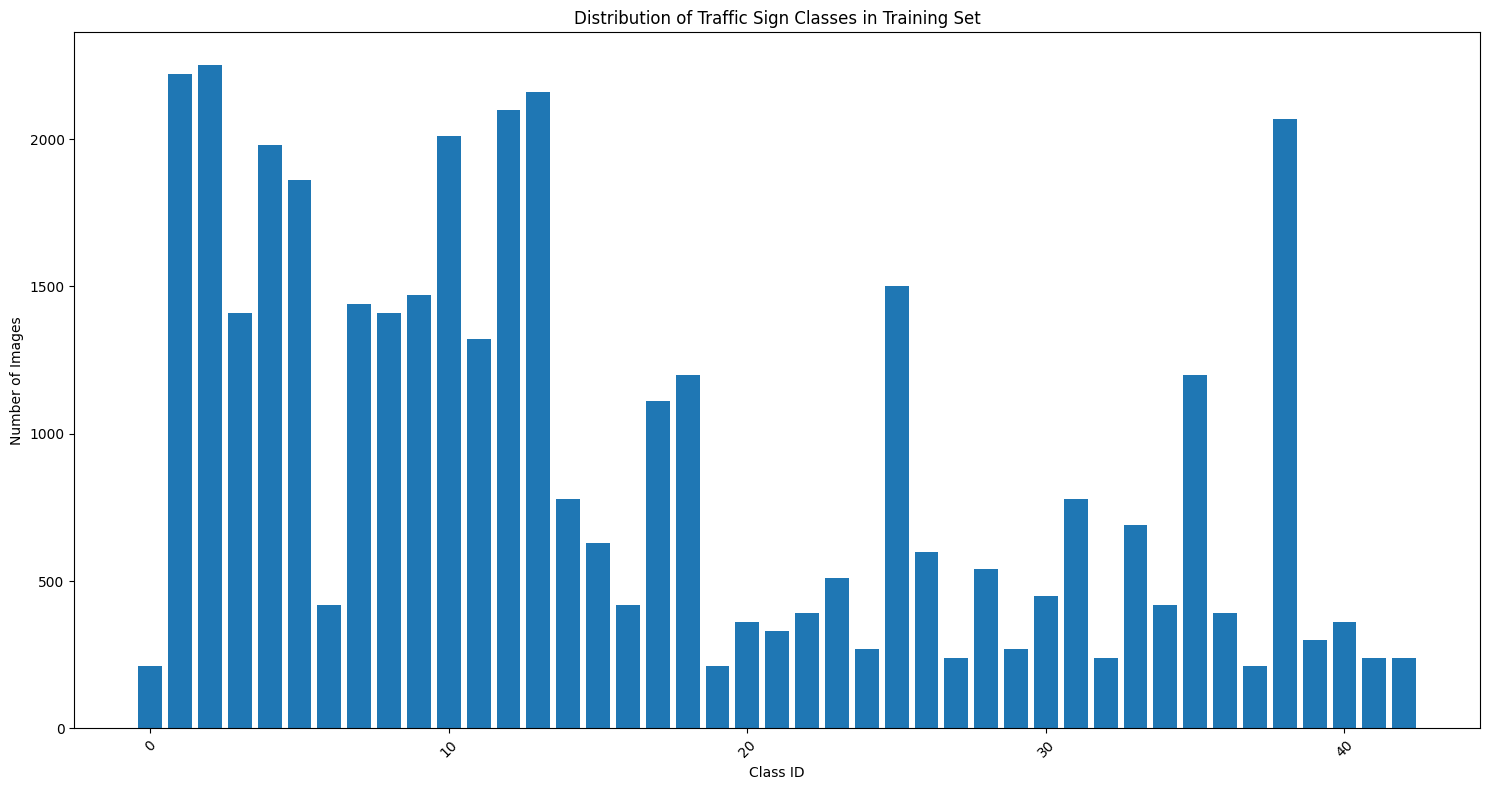


Class distribution statistics:
Mean images per class: 911.84
Std images per class: 695.86
Min images per class: 210
Max images per class: 2250


In [ ]:
class_counts = train_df['ClassId'].value_counts().sort_index()
print(f"Number of classes: {len(class_counts)}")
print(f"Class range: {train_df['ClassId'].min()} to {train_df['ClassId'].max()}")

plt.figure(figsize=(15, 8))
plt.bar(class_counts.index, class_counts.values)
plt.title('Distribution of Traffic Sign Classes in Training Set')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nClass distribution statistics:")
print(f"Mean images per class: {class_counts.mean():.2f}")
print(f"Std images per class: {class_counts.std():.2f}")
print(f"Min images per class: {class_counts.min()}")
print(f"Max images per class: {class_counts.max()}")


Sample images from different classes:


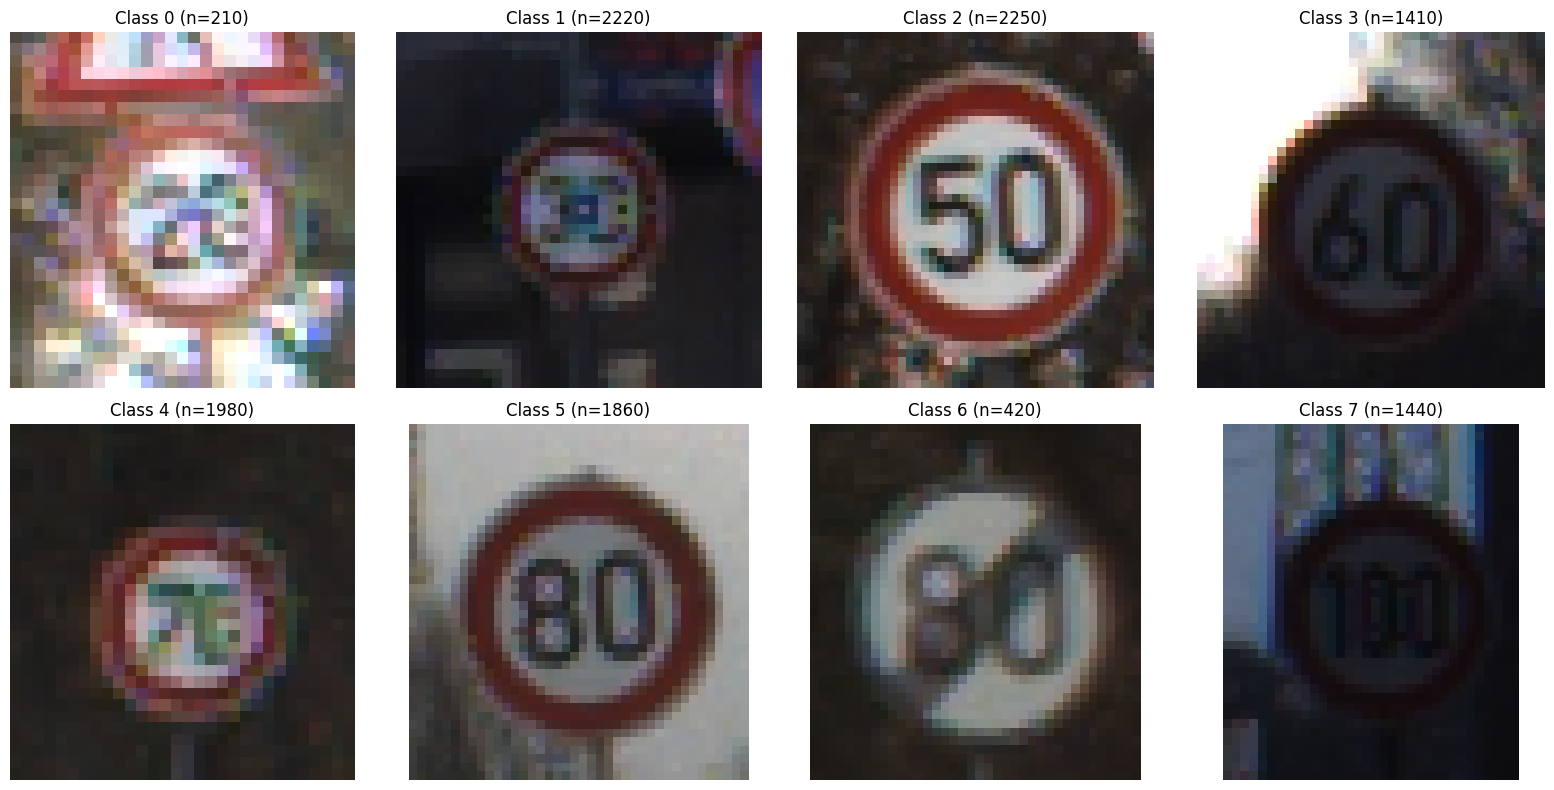

In [ ]:
def display_sample_images(df, num_samples=5, num_classes=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i in range(min(num_classes, 8)):
        class_id = class_counts.index[i]
        class_images = df[df['ClassId'] == class_id]
        
        if len(class_images) > 0:
            sample_img = class_images.sample(1).iloc[0]
            img_path = sample_img['Path']
            
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img)
                axes[i].set_title(f'Class {class_id} (n={len(class_images)})')
                axes[i].axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                axes[i].text(0.5, 0.5, f'Error\nClass {class_id}', 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].axis('off')
    
    for i in range(num_classes, 8):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample images")
display_sample_images(train_df)


##  Data Preprocessing


In [ ]:
IMG_SIZE = 32
NUM_CLASSES = 43
BATCH_SIZE = 32

def preprocess_image(img_path, img_size=IMG_SIZE):
    try:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype(np.float32) / 255.0
        return img
    except Exception as e:
        print(f"Error preprocessing image {img_path}: {e}")
        return None

def load_data(df, img_size=IMG_SIZE):
    images = []
    labels = []
    print(f"Loading {len(df)} images...")
    for idx, row in df.iterrows():
        if idx % 1000 == 0:
            print(f"Processed {idx}/{len(df)} images")
        img_path = row['Path']
        class_id = row['ClassId']
        img = preprocess_image(img_path, img_size)
        if img is not None:
            images.append(img)
            labels.append(class_id)
    return np.array(images), np.array(labels)

print("Preprocessing functions defined.")


Preprocessing functions defined.


In [6]:
# Load training data
print("Loading training data...")
X_train, y_train = load_data(train_df)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Unique classes in training: {len(np.unique(y_train))}")
print(f"Class range: {y_train.min()} to {y_train.max()}")


Loading training data...
Loading 39209 images...
Processed 0/39209 images
Processed 1000/39209 images
Processed 2000/39209 images
Processed 3000/39209 images
Processed 4000/39209 images
Processed 5000/39209 images
Processed 6000/39209 images
Processed 7000/39209 images
Processed 8000/39209 images
Processed 9000/39209 images
Processed 10000/39209 images
Processed 11000/39209 images
Processed 12000/39209 images
Processed 13000/39209 images
Processed 14000/39209 images
Processed 15000/39209 images
Processed 16000/39209 images
Processed 17000/39209 images
Processed 18000/39209 images
Processed 19000/39209 images
Processed 20000/39209 images
Processed 21000/39209 images
Processed 22000/39209 images
Processed 23000/39209 images
Processed 24000/39209 images
Processed 25000/39209 images
Processed 26000/39209 images
Processed 27000/39209 images
Processed 28000/39209 images
Processed 29000/39209 images
Processed 30000/39209 images
Processed 31000/39209 images
Processed 32000/39209 images
Process

In [ ]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set size: {X_train_split.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {len(test_df)}")

y_train_categorical = to_categorical(y_train_split, NUM_CLASSES)
y_val_categorical = to_categorical(y_val, NUM_CLASSES)


Training set size: 31367
Validation set size: 7842
Test set size: 12630

Categorical labels shape - Train: (31367, 43), Val: (7842, 43)


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

print("Data augmentation configured.")


Data augmentation configured.


##  CNN Model Architecture


In [ ]:
def create_cnn_model(input_shape=(32, 32, 3), num_classes=43):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_cnn_model()

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 1,451,211 (5.54 MB)

 Trainable params: 1,448,715 (5.53 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully.")


Model compiled successfully.


##  Training the Model


In [ ]:
# Define callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_traffic_sign_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured.")


Callbacks configured.


In [ ]:
print("Starting model training...")
print(f"Training samples: {X_train_split.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Batch size: {BATCH_SIZE}")

history = model.fit(
    train_datagen.flow(X_train_split, y_train_categorical, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train_split) // BATCH_SIZE,
    epochs=50,
    validation_data=val_datagen.flow(X_val, y_val_categorical, batch_size=BATCH_SIZE),
    validation_steps=len(X_val) // BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1
)

print("Training completed!")


Starting model training...
Training samples: 31367
Validation samples: 7842
Batch size: 32
Epoch 1/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0731 - loss: 4.1214
Epoch 1: val_accuracy improved from None to 0.13291, saving model to best_traffic_sign_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.1166 - loss: 3.5405 - val_accuracy: 0.1329 - val_loss: 3.2319 - learning_rate: 0.0010
Epoch 2/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.4062 - loss: 2.4809
Epoch 2: val_accuracy did not improve from 0.13291
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4062 - loss: 2.4809 - val_accuracy: 0.1320 - val_loss: 3.2280 - learning_rate: 0.0010
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3208 - loss: 2.2076
Epoch 3: val_accuracy improved from 0.13291 to 0.66135, saving model to best_traffic_sign_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 31s 31ms/step - accuracy: 0.4042 - loss: 1.8702 - val_accuracy: 0.6614 - val_loss: 0.9784 - learning_rate: 0.0010
Epoch 4/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.6250 - loss: 1.0869
Epoch 4: val_accuracy improved from 0.66135 to 0.67041, saving model to best_traffic_sign_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6250 - loss: 1.0869 - val_accuracy: 0.6704 - val_loss: 0.9560 - learning_rate: 0.0010
Epoch 5/50
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6212 - loss: 1.1082
Epoch 5: val_accuracy improved from 0.67041 to 0.83482, saving model to best_traffic_sign_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.6769 - loss: 0.9629 - val_accuracy: 0.8348 - val_loss: 0.4797 - learning_rate: 0.0010
Epoch 6/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.8438 - loss: 0.6636
Epoch 6: val_accuracy improved from 0.83482 to 0.83648, saving model to best_traffic_sign_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8438 - loss: 0.6636 - val_accuracy: 0.8365 - val_loss: 0.4742 - learning_rate: 0.0010
Epoch 7/50
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7933 - loss: 0.6403
Epoch 7: val_accuracy improved from 0.83648 to 0.94541, saving model to best_traffic_sign_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.8201 - loss: 0.5665 - val_accuracy: 0.9454 - val_loss: 0.1761 - learning_rate: 0.0010
Epoch 8/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9062 - loss: 0.3040
Epoch 8: val_accuracy improved from 0.94541 to 0.94707, saving model to best_traffic_sign_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9062 - loss: 0.3040 - val_accuracy: 0.9471 - val_loss: 0.1722 - learning_rate: 0.0010
Epoch 9/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8815 - loss: 0.3880
Epoch 9: val_accuracy improved from 0.94707 to 0.95829, saving model to best_traffic_sign_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.8899 - loss: 0.3613 - val_accuracy: 0.9583 - val_loss: 0.1343 - learning_rate: 0.0010
Epoch 10/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.9375 - loss: 0.1386
Epoch 10: val_accuracy improved from 0.95829 to 0.96212, saving model to best_traffic_sign_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.1386 - val_accuracy: 0.9621 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 11/50
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9165 - loss: 0.2776
Epoch 11: val_accuracy improved from 0.96212 to 0.99260, saving model to best_traffic_sign_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9219 - loss: 0.2605 - val_accuracy: 0.9926 - val_loss: 0.0279 - learning_rate: 0.0010
Epoch 12/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9062 - loss: 0.2100
Epoch 12: val_accuracy did not improve from 0.99260
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9062 - loss: 0.2100 - val_accuracy: 0.9922 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 13/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9301 - loss: 0.2364
Epoch 13: val_accuracy did not improve from 0.99260
980/980 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9389 - loss: 0.2127 - val_accuracy: 0.9867 - val_loss: 0.0512 - learning_rate: 0.0010
Epoch 14/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.9375 - loss: 0.1250
Epoch 14: val_accuracy did not improve from 0.99260
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.1250 - val_accuracy: 0.9866 - val_loss: 0.0525 - learning_rate: 0.0010
Epoch 15/5

980/980 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.9712 - loss: 0.1071 - val_accuracy: 0.9971 - val_loss: 0.0126 - learning_rate: 5.0000e-04
Epoch 18/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9375 - loss: 0.1987
Epoch 18: val_accuracy did not improve from 0.99707
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.1987 - val_accuracy: 0.9971 - val_loss: 0.0127 - learning_rate: 5.0000e-04
Epoch 19/50
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9769 - loss: 0.0884
Epoch 19: val_accuracy did not improve from 0.99707
980/980 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.9771 - loss: 0.0868 - val_accuracy: 0.9958 - val_loss: 0.0144 - learning_rate: 5.0000e-04
Epoch 20/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 1.0000 - loss: 0.0129
Epoch 20: val_accuracy did not improve from 0.99707
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 0.9955 - val_loss: 0.0146 - learning_rate: 5.000

980/980 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9854 - loss: 0.0563 - val_accuracy: 0.9985 - val_loss: 0.0060 - learning_rate: 2.5000e-04
Epoch 24/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 1.0000 - loss: 0.0051
Epoch 24: val_accuracy did not improve from 0.99847
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9985 - val_loss: 0.0060 - learning_rate: 2.5000e-04
Epoch 25/50
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9849 - loss: 0.0560
Epoch 25: val_accuracy did not improve from 0.99847
980/980 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9854 - loss: 0.0549 - val_accuracy: 0.9983 - val_loss: 0.0057 - learning_rate: 2.5000e-04
Epoch 26/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 30s 31ms/step - accuracy: 1.0000 - loss: 0.0098
Epoch 26: val_accuracy did not improve from 0.99847
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 0.9983 - val_loss: 0.0057 - learning_rate: 2.500

980/980 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.9876 - loss: 0.0454 - val_accuracy: 0.9995 - val_loss: 0.0023 - learning_rate: 2.5000e-04
Epoch 30/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9375 - loss: 0.1166
Epoch 30: val_accuracy did not improve from 0.99949
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.1166 - val_accuracy: 0.9995 - val_loss: 0.0023 - learning_rate: 2.5000e-04
Epoch 31/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9890 - loss: 0.0411
Epoch 31: val_accuracy did not improve from 0.99949
980/980 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.9889 - loss: 0.0419 - val_accuracy: 0.9994 - val_loss: 0.0043 - learning_rate: 2.5000e-04
Epoch 32/50
  1/980 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9688 - loss: 0.1313
Epoch 32: val_accuracy did not improve from 0.99949
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9688 - loss: 0.1313 - val_accuracy: 0.9994 - val_loss: 0.0043 - learning_rate: 2.500

## Training Visualization


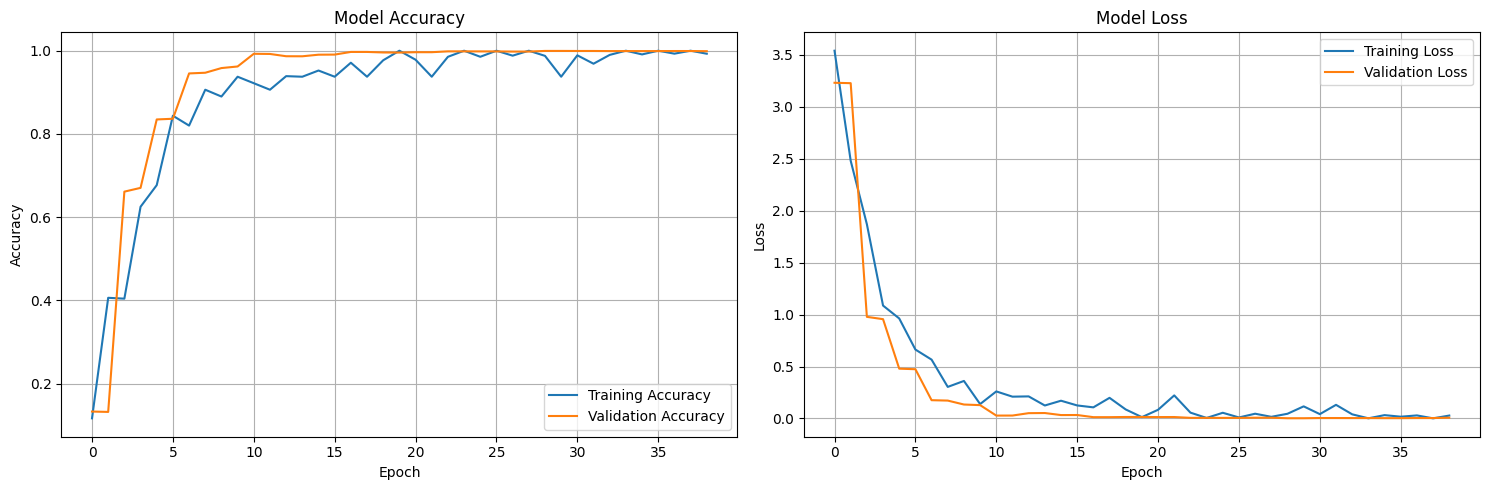

In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


##  Model Evaluation


In [ ]:
best_model = keras.models.load_model('best_traffic_sign_model.h5')

val_loss, val_accuracy = best_model.evaluate(X_val, y_val_categorical, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


Validation Accuracy: 0.9995
Validation Loss: 0.0023


In [ ]:
print("Loading test data...")
X_test, y_test = load_data(test_df)
y_test_categorical = to_categorical(y_test, NUM_CLASSES)

print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

test_loss, test_accuracy = best_model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Loading test data...
Loading 12630 images...
Processed 0/12630 images
Processed 1000/12630 images
Processed 2000/12630 images
Processed 3000/12630 images
Processed 4000/12630 images
Processed 5000/12630 images
Processed 6000/12630 images
Processed 7000/12630 images
Processed 8000/12630 images
Processed 9000/12630 images
Processed 10000/12630 images
Processed 11000/12630 images
Processed 12000/12630 images
Test data shape: (12630, 32, 32, 3)
Test labels shape: (12630,)

Test Accuracy: 0.9808
Test Loss: 0.1050


In [ ]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))


395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Test Accuracy: 0.9808

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.99      0.99      0.99       450
           4       1.00      0.99      0.99       660
           5       0.99      0.98      0.99       630
           6       0.99      0.97      0.98       150
           7       0.98      1.00      0.99       450
           8       1.00      1.00      1.00       450
           9       0.99      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.97      0.98       420
          12       1.00      0.98      0.99       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       1.00      0.99      0.99    

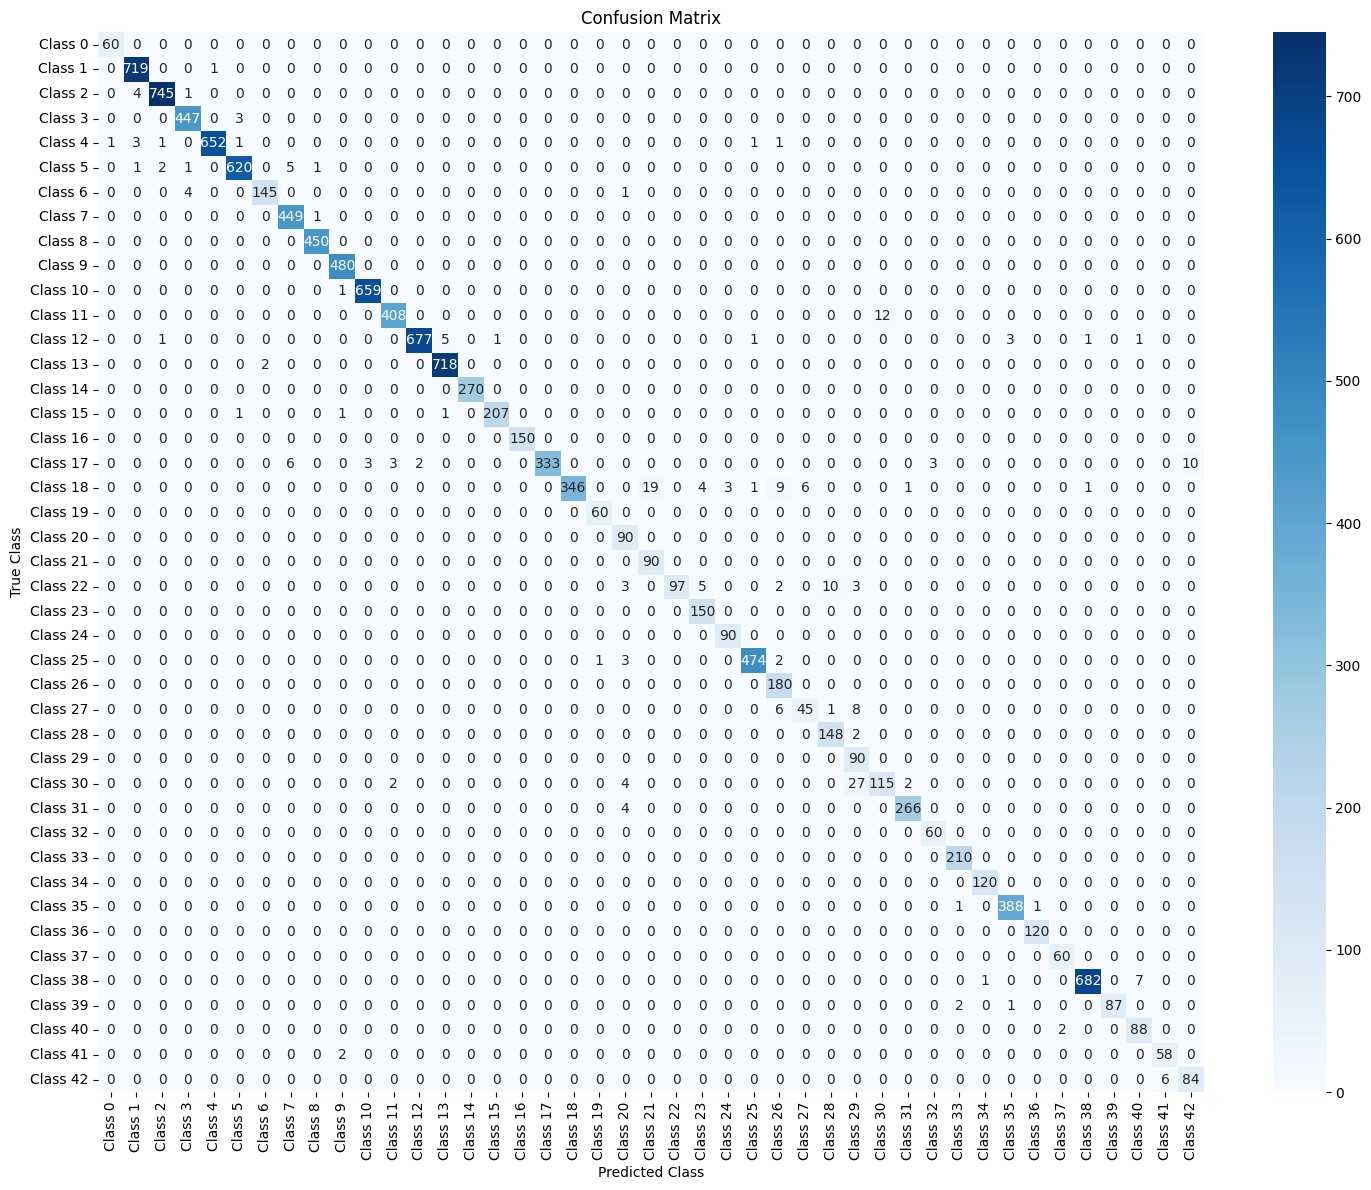


Per-class accuracy (first 10 classes):
Class 0: 1.0000
Class 1: 0.9986
Class 2: 0.9933
Class 3: 0.9933
Class 4: 0.9879
Class 5: 0.9841
Class 6: 0.9667
Class 7: 0.9978
Class 8: 1.0000
Class 9: 1.0000


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.tight_layout()
    plt.show()
    
    return cm

class_names = [f'Class {i}' for i in range(NUM_CLASSES)]
cm = plot_confusion_matrix(y_test, y_pred_classes, class_names)

per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class accuracy (first 10 classes):")
for i in range(min(10, len(per_class_accuracy))):
    print(f"Class {i}: {per_class_accuracy[i]:.4f}")


Sample predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


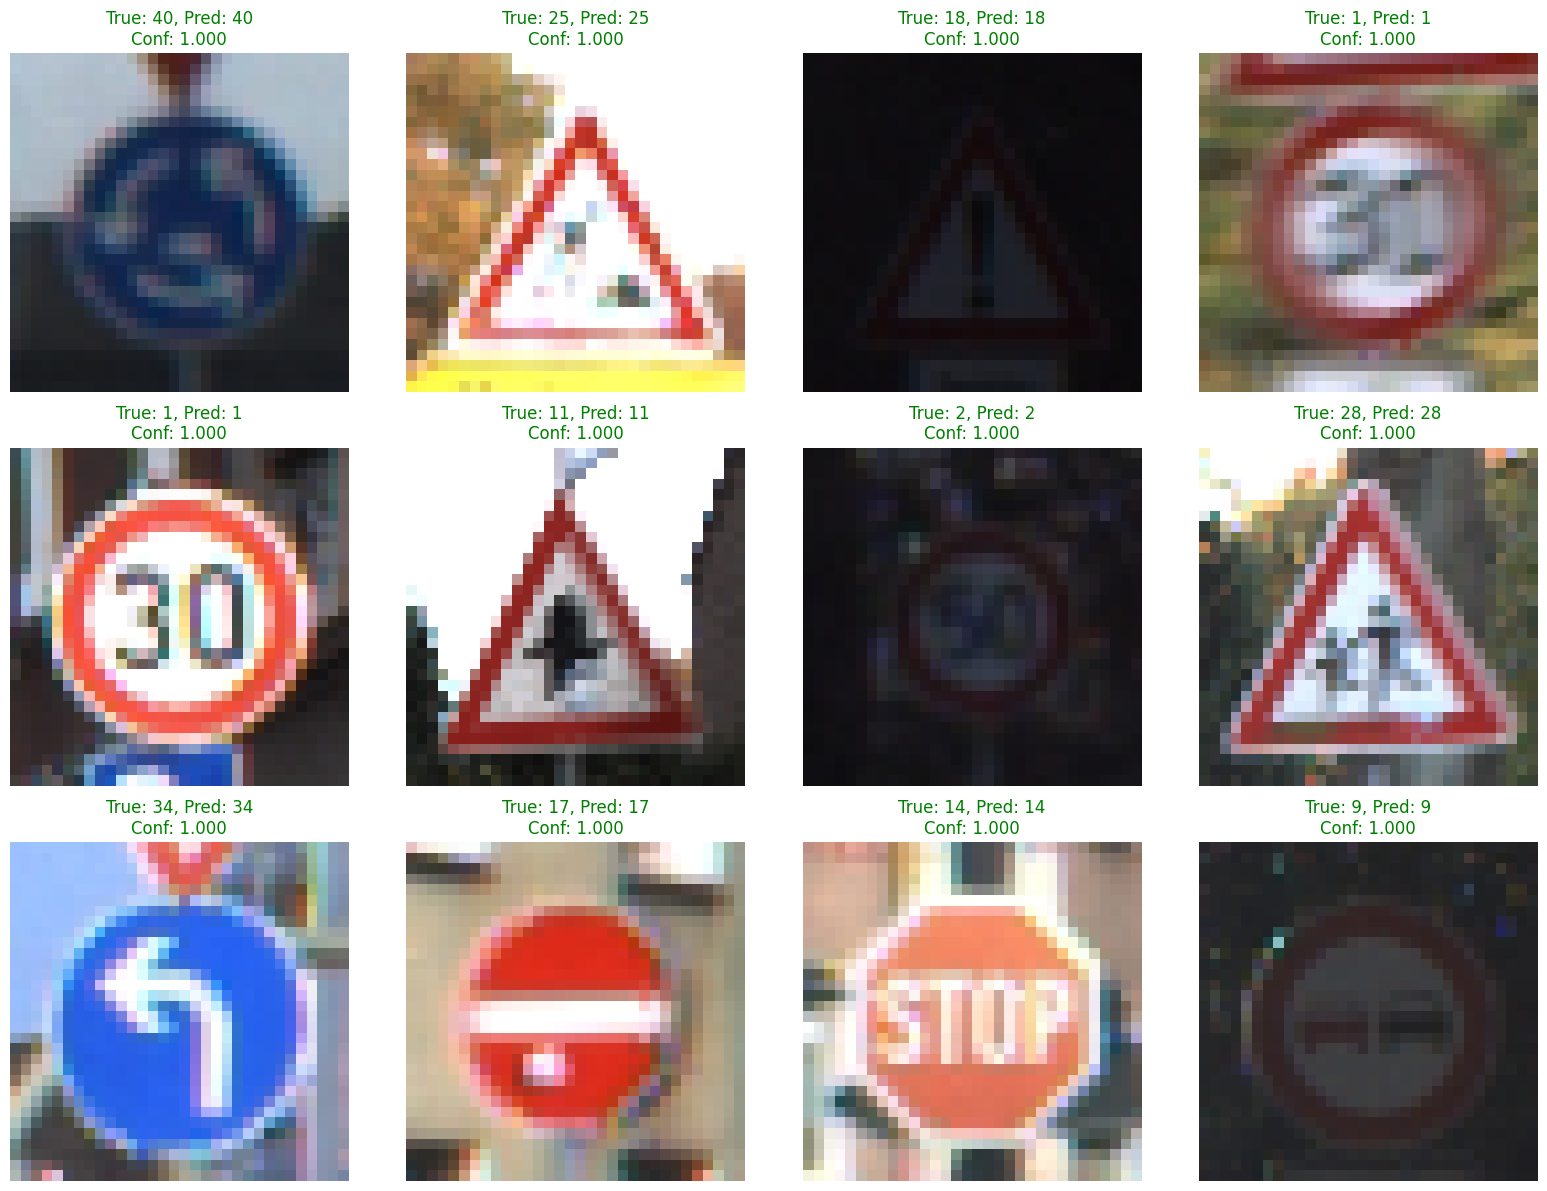

In [ ]:
def display_sample_predictions(X_test, y_test, y_pred, num_samples=12):
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
   
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        confidence = np.max(best_model.predict(img.reshape(1, 32, 32, 3)))
        
        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.3f}', 
                         color='green' if true_label == pred_label else 'red')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample predictions:")
display_sample_predictions(X_test, y_test, y_pred_classes)


Number of misclassified samples: 243
Misclassification rate: 0.0192

Some misclassified examples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


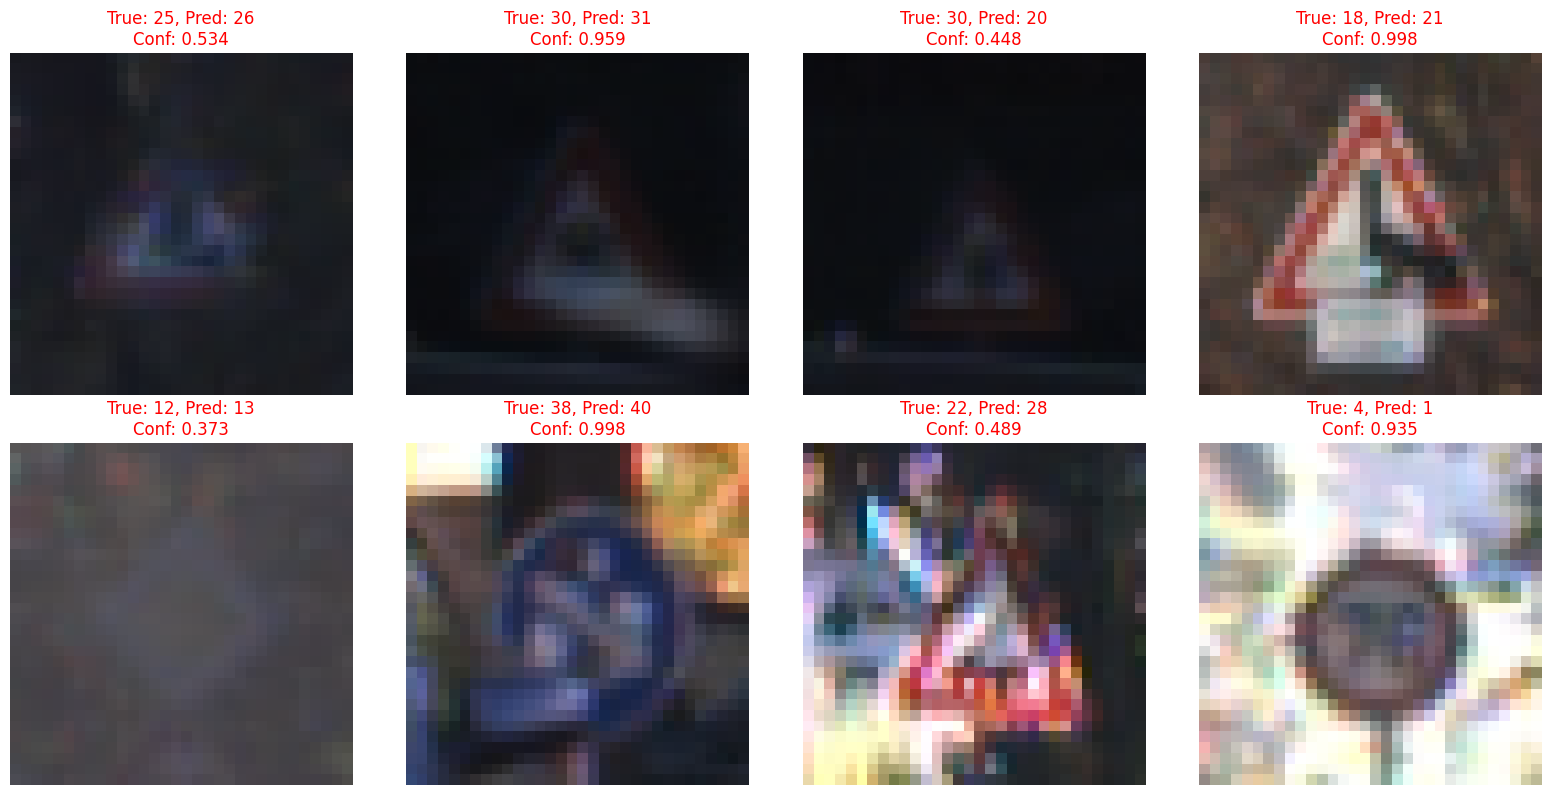

In [ ]:
misclassified_indices = np.where(y_test != y_pred_classes)[0]
print(f"Number of misclassified samples: {len(misclassified_indices)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(y_test):.4f}")

if len(misclassified_indices) > 0:
    print("\nSome misclassified examples:")
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(misclassified_indices[:8]):
        img = X_test[idx]
        true_label = y_test[idx]
        pred_label = y_pred_classes[idx]
        confidence = np.max(best_model.predict(img.reshape(1, 32, 32, 3)))
        
        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.3f}', 
                         color='red')
        axes[i].axis('off')
    
    for i in range(len(misclassified_indices), 8):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [20]:
# Summary statistics
print("=== MODEL PERFORMANCE SUMMARY ===")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Number of Parameters: {best_model.count_params():,}")
print(f"Model Size: {best_model.count_params() * 4 / (1024 * 1024):.2f} MB")

print("\n=== CLASSIFICATION METRICS ===")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Misclassification Rate: {1-accuracy:.4f}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Training Samples: {len(X_train_split):,}")
print(f"Validation Samples: {len(X_val):,}")
print(f"Test Samples: {len(X_test):,}")


=== MODEL PERFORMANCE SUMMARY ===
Final Training Accuracy: 0.9928
Final Validation Accuracy: 0.9989
Test Accuracy: 0.9808
Test Loss: 0.1050
Number of Parameters: 1,451,211
Model Size: 5.54 MB

=== CLASSIFICATION METRICS ===
Overall Accuracy: 0.9808
Misclassification Rate: 0.0192
Number of Classes: 43
Training Samples: 31,367
Validation Samples: 7,842
Test Samples: 12,630
